In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import xarray as xr
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
import tensorflow

#Tuve problemas con tensorflow cuando me cambié a Mac, te puedo ayudar si estás muy complicado

In [3]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import AveragePooling2D, LSTM, Dense,Dropout

In [126]:
#Ubicación de los archivos

#path = r"/Users/javier/Documents/Data/"     
path2 = r"/Users/javier/Downloads/"

dswind= xr.open_dataset(path2 + 'SLP.nc') # set de presión

df0 = pd.read_csv(path2 + 'NCEP_Spectra2.csv',index_col='Unnamed: 0')  #Sólo los parámetros de oleaje, no es el espectro completo.



Desde = '2009-01-01 03:00:00'

Hasta = '2009-12-30 21:00:00'

#Datos de Presión 

Presion = dswind.msl.sel(time=slice(Desde,  Hasta),longitude=slice(-130,-60),latitude=slice(-20,-70))

Hm0 = df0[Desde: Hasta]['Hm0']

Fechas = df0[Desde: Hasta].index

### BCA: no me gusta perder la información de las fechas. 
### en principio puedes hacer todo con el índice, y sólo al momento de ajustar tu regresor 
### darle los datos y quedarte tú con las fechas

# cuando manipulo los datos usando .data, se pierden los índices, por lo que al primer reshape, pierdo el indice
# lo mejor que puedo hacer es guardar en Fechas los índices, y procurar que no se desordenen los indices.

In [93]:
'''
Hace un avarage pooling y luego un flatten si se le pide.

'''

### Si bien entiendo que el pooling se hace para que sea más rápido... probaste hacerlo sin pooling?

# Probé varias veces. se demora mucho más y no soluciona el problema.

###  Nunca lo había visto usado fuera de una NN. Quizás es útil, quizás más complicado de lo necesario?

# esque si no lo usamos, a la red neuronal después le entran miles de parámetros y se demora demasiado, estaría de acuerdo con sacarlo pero agregando una convolución a cambio.

def resize(Wind,i,flat=False):
    
    Wind = Wind.reshape(Wind.shape[0], Wind.shape[1], Wind.shape[2],1)

    Average_pool = AveragePooling2D(pool_size = 10*i, strides= 10*i) #el poolsize y stride, están pensados para las futuras iteraciones

    model = Sequential([Average_pool]) 

    output = model.predict(Wind)    
    
    Wind = np.squeeze(output) 
    
    
    if flat:
        
        Wind = Wind.reshape(Wind.shape[0],-1)
    
    
    return Wind


def gradiente(X):
    
    grad = np.zeros(X.shape)
    
    for i in range(1,grad.shape[1]-1):
        
        for j in range(1,grad.shape[2]-1):
            
            grad[:,i,j] = np.sqrt((X[:,i-1,j]-X[:,i+1,j])**2 + (X[:,i,j-1]-X[:,i,j+1])**2) #magnitud de gradiente aunque le falta ser dividida por el diferencial de distancia entre puntos, pero al ser constante para todos los valores no debería afectar.
    
    return grad


def flatten(Var):
    
    return Var.reshape(Var.shape[0], Var.shape[1]*Var.shape[2])

In [127]:
shape = Presion.data.shape

Pres = resize(Presion.data, 1, False)  

print(shape)
#Probe sin pooling y el código es muy muy lento y no entrega mejores resultados 

(2911, 201, 281)


In [128]:
Gradiente = flatten(gradiente(Pres))

Pres = flatten(Pres)

In [129]:
X = np.append(Pres,Gradiente,axis=1)  #al juntar presión con gradiente, desp tendrémos un problema para escalar, porque tienen valores muy distintos.

Y = np.array(Hm0).reshape(-1,1)

#se pierde el indice, pero está guardado en Fechas.

In [108]:
'''
Aquí se divide la serie de tiempo en sub series de tiempo de tamaño timestep.

Input dim: (Serie/timestep, timestep, parámetro)
'''    

### me parece que esto es más complicado de lo necesario...
### porque no usar simplemente reshape?
### hint: tratar de mantener los índices para estar seguro que todo calza

# cambié el for por un reshape, funciona igual pero más rápido

def dividir(Var, step):

    return Var[:(Var.shape[0]//step)*step].reshape(Var.shape[0]//step, step, Var.shape[1])


def juntar(Var):
    
    return Var.reshape(Var.shape[0]*Var.shape[1],1)

In [110]:
#para mostrar como divide

u = np.arange(1,21).reshape(-1,1)

dividir(u, 5)

In [63]:
#para mostrar como junta 

juntar(dividir(u, 5))

#podemos ver que el proceso de división y juntado está funcionando bien.

In [130]:
'''
Preparamos los datos para modelar.
'''

### escalar siempre es buena idea, pero hay que hacerlo consistentemente
### en este código cada variable, X e Y, están siendo escaladas de forma distinta
### más aún: nuevos X e Y serán escalados de forma distinta
### has probado hacerlo sin escalar?
### https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

# He probado escalando cada variable con un "escalador" MinMax distinto,
# y he probado también sin escalar de todas las combinaciones. Solo empeora.


scx = MinMaxScaler([0,1])

scx2 = MinMaxScaler([0,1])

timestep = 1000


X_div =  dividir(scx.fit_transform(X), timestep)

Y_div = dividir(scx2.fit_transform(Y), timestep)

m = X_div.shape[0]

x_train, x_test = X_div[:int(m*0.8)], X_div[int(m*0.8):]

y_train, y_test = Y_div[:int(m*0.8)], Y_div[int(m*0.8):]


In [112]:

print('X_train shape: ', x_train.shape)
print('Y_train shape: ', y_train.shape)


### originalmente esto dice:
# X_train shape:  (1, 1000, 54)
# Y_train shape:  (1, 1000, 1)

### pero según tu esquema esto debería tener forma (numero de params, numero de timesteps, cantidad de muestras) para X
### y para Y debería ser (1, numero de timesteps, cantidad de muestras)

#### JH: La forma es (muestras, timesteps, parámetros),el esquema se está explicando mal o alreves, lo arreglaré.



X_train shape:  (1, 1000, 1120)
Y_train shape:  (1, 1000, 1)


In [131]:
### esta es la arquitectura del paper?
### creo que hecho de menos unos layers dropout

model = Sequential()

model.add(LSTM(units= 128,return_sequences=False ,input_shape=(x_train.shape[1],x_train.shape[2])))

#model.add(LSTM(units= y_train.shape[1]))

model.add(Dense(units=y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

model.fit(x_train,y_train,epochs= 30,batch_size=1)#,validation_split=0)

Epoch 1/30
1/1 [==============================] - 1s 1s/step - loss: 0.2270
Epoch 2/30
1/1 [==============================] - 0s 337ms/step - loss: 0.1839
Epoch 3/30
1/1 [==============================] - 0s 340ms/step - loss: 0.1622
Epoch 4/30
1/1 [==============================] - 0s 348ms/step - loss: 0.1425
Epoch 5/30
1/1 [==============================] - 0s 343ms/step - loss: 0.1212
Epoch 6/30
1/1 [==============================] - 0s 342ms/step - loss: 0.0992
Epoch 7/30
1/1 [==============================] - 0s 345ms/step - loss: 0.0788
Epoch 8/30
1/1 [==============================] - 0s 352ms/step - loss: 0.0618
Epoch 9/30
1/1 [==============================] - 0s 351ms/step - loss: 0.0487
Epoch 10/30
1/1 [==============================] - 0s 331ms/step - loss: 0.0385
Epoch 11/30
1/1 [==============================] - 0s 335ms/step - loss: 0.0303
Epoch 12/30
1/1 [==============================] - 0s 338ms/step - loss: 0.0238
Epoch 13/30
1/1 [==============================] - 0

In [132]:
'''
Hace la inversa a los datos luego de obtener la estimación.
'''
### mismo comentario anteior
### fijate que scx no ha sido seteado por ningun set de datos
### como sabe scx con qué valores re-escalar?
### si bien es util escalar porque aumenta la presición... no será mejor partir con los datos tal cual?
### hay que ir agregando complejidad sólo a medida que sea necesario

y_pred_train = scx2.inverse_transform(juntar(model.predict(x_train)))

y_train = scx2.inverse_transform(juntar(y_train))

y_pred_test = scx2.inverse_transform(juntar(model.predict(x_test)))

y_test = scx2.inverse_transform(juntar(y_test))

### adicionalmente, haces una predición, pero no hay cómo saber a qué fechas corresponden

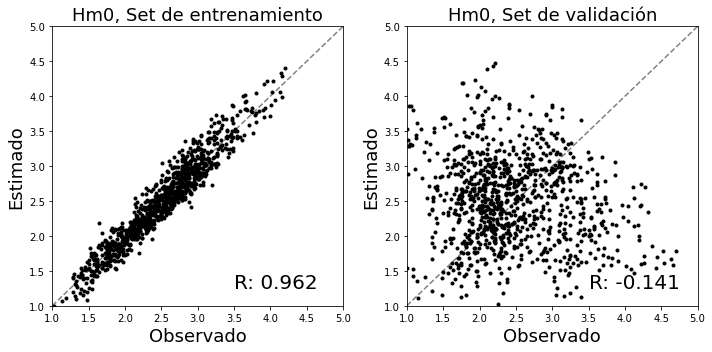

In [133]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].set_title('Hm0, Set de entrenamiento',fontsize=18)
axs[0].plot([1,5],[1,5],'--',0.5,color='grey')
axs[0].plot(y_train[:3000],y_pred_train[:3000],'.',color='Black')
axs[0].set_xlabel('Observado',size=18)
axs[0].set_ylabel('Estimado',size=18)
axs[0].set_ylim(1,5)
axs[0].set_xlim(1,5)
axs[0].text(3.5,1.25,'R: '+str(np.round(np.corrcoef(y_train.T,(y_pred_train).T)[0,1],3)),size=20)


axs[1].set_title('Hm0, Set de validación',fontsize=18)
axs[1].plot([1,5],[1,5],'--',0.5,color='grey')
axs[1].plot(y_test[:3000],y_pred_test[:3000],'.',color='Black')
axs[1].set_xlabel('Observado',size=18)
axs[1].set_ylabel('Estimado',size=18)
axs[1].set_ylim(1,5)
axs[1].set_xlim(1,5)
axs[1].text(3.5,1.25,'R: '+str(np.round(np.corrcoef(y_test.T,y_pred_test.T)[0,1],3)),size=20)

fig.set_facecolor('w')
fig.tight_layout()
plt.show()

fig.savefig("Pred_LSTM_presion y grad_500var_50epochs_con escalar",dpi=300)
